# Transforming between coordinate systems - Coordinates series 2

What we assume you:
- Have basic knowledge of coordinate systems and the astropy coordinate library
- How to work with python classes (note: you do not need to know how to write classes)
- How to work with numpy arrays

By the time you are done you should be able to:
- Make coordinate objects
- Transform to different coordinate systems
- See how to track an object's altitude from certain observing locations

### Imports

In [1]:
# Python standard-library
from urllib.parse import urlencode
from urllib.request import urlretrieve

# Third-party dependencies
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
from IPython.display import Image

In [2]:
# Set up matplotlib and use a nicer set of plot parameters
from astropy.visualization import astropy_mpl_style
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
%matplotlib inline

# Section 0: Quickstart

<div class="alert alert-info">

**Note:** If you already worked through tutorial one, you can feel free to skip to [Section 1](#Section-1:).

</div>

In Astropy, the most common object you'll work with for coordinates is `SkyCoord`.  A `SkyCoord` can be created most easily directly from angles as shown below.  

In this tutorial we will be converting between frames. Let's start in the ICRS frame (which happens to be the default). 

For much of this tutorial we will work with the Hickson Compact Group 7. We can create an object either by passing the degrees explicitly (using the astropy [units](http://docs.astropy.org/en/stable/units/index.html) library) or by passing in strings. The two coordinates below are equivalent

In [3]:
hcg7_center = SkyCoord(9.81625*u.deg, 0.88806*u.deg, frame='icrs')  # using degrees directly
print(hcg7_center)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 9.81625,  0.88806)>


In [4]:
hcg7_center = SkyCoord('0h39m15.9s', '0d53m17.016s', frame='icrs')  # passing in string format
print(hcg7_center)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 9.81625,  0.88806)>


We can get the right ascension and declination components of the object directly by accessing those attributes.

In [5]:
print(hcg7_center.ra)
print(hcg7_center.dec)

9d48m58.5s
0d53m17.016s


# Section 1: 

### Introducting frame transformations

`astropy.coordinates` provides many tools to transform between different coordinate systems. For instance, we can use it to transform from ICRS coordinates (in ra and dec) to galactic coordinates.

To understand the code in this section, it may help to read over the [overview of the astropy coordinates scheme](http://astropy.readthedocs.org/en/latest/coordinates/index.html#overview-of-astropy-coordinates-concepts).  The key bit to understand is that all coordinates in astropy are in particular "frames", and we can transform between a specific `SkyCoord` object from one frame to another.  For example, we can transform our previously-defined center of HCG7 from ICRS to Galactic coordinates:

In [74]:
hcg7_center = SkyCoord(9.81625*u.deg, 0.88806*u.deg, frame='icrs')

There are three different ways of transforming coordinates. Each has it's pros and cons, but should give you the same result. The first way to transform to other built-in frames is by specifying those attributes. For instance, let's see the location of HCG7 in galactic coordinates.

#### Transforming coordinates using attributes:

In [69]:
hcg7_center.galactic

<SkyCoord (Galactic): (l, b) in deg
    ( 116.47556813, -61.83099472)>

#### Transforming coordinates using the transform_to() method and other Coordinate object

The above is actually a special "quick-access" form which internally does the same as what's in the cell below: uses the [`transform_to()`](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.transform_to) method to convert from one frame to another. We can pass in an empty coordinate class to specify what coordinate system to transform into.

In [76]:
from astropy.coordinates import Galactic  # new coordinate baseclass
hcg7_center.transform_to(Galactic())

<SkyCoord (Galactic): (l, b) in deg
    ( 116.47556813, -61.83099472)>

#### Transforming coordinates using the transform_to() method and a string

Finally, we can transform using the `transform_to()` method and a string with the name of a built-in coordinate system.

In [75]:
hcg7_center.transform_to('galactic')

<SkyCoord (Galactic): (l, b) in deg
    ( 116.47556813, -61.83099472)>

We can transform to many coordinate frames and equinoxes. 

By default these coordinates are available:

 - ICRS
 - FK5
 - FK4
 - FK4NoETerms
 - Galactic
 - Galactocentric
 - Supergalactic
 - AltAz
 - GCRS
 - CIRS
 - ITRS
 - HCRS
 - PrecessedGeocentric
 - GeocentricTrueEcliptic'
 - BarycentricTrueEcliptic
 - HeliocentricTrueEcliptic'
 - SkyOffsetFrame
 - GalacticLSR
 - LSR
 - BaseEclipticFrame
 - BaseRADecFrame

Let's focus on just a few of these. We can try FK5 coordinates next:

In [34]:
hcg7_center_fk5 = hcg7_center.transform_to('fk5')  # c_icrs.fk5 does the same thing
print(hcg7_center_fk5)

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    ( 9.81625645,  0.88806155)>


And, as with the galactic coordinates, we can acheive the same result by importing the FK5 class from the astropy.coordinates package. This also allows us to change the equinox.

In [35]:
from astropy.coordinates import FK5
hcg7_center_fk5.transform_to(FK5(equinox='J1975'))  # precess to a different equinox  

<SkyCoord (FK5: equinox=J1975.000): (ra, dec) in deg
    ( 9.49565759,  0.75084648)>

<div class="alert alert-warning">

**Beware:** Changing frames also changes some of the attributes of the object, but usually in a way that makes sense. The following code should fail.

</div>

In [36]:
hcg7_center.galactic.ra  # should fail because galactic coordinates are l/b not RA/Dec

AttributeError: 'SkyCoord' object has no attribute 'ra'

Instead, we now have access the l and b attributes:

In [12]:
print(hcg7_center.galactic.l, hcg7_center.galactic.b)

116d28m32.0453s -61d49m51.581s


# Section 2:

## Transform frames to get to AltAz


To actually do anything with observability we need to convert to a frame local to an on-earth observer.  By far the most common choice is horizontal coordinates, or "AltAz" coordinates.  We first need to specify both where and when we want to try to observe.

We will need to import a few more specific modules:

In [37]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

Lets first see the sky position at Kitt Peak National Observatory in Arizona.

In [38]:
# Kitt Peak, Arizona
kitt_peak = EarthLocation(lat='31d57.5m', lon='-111d35.8m', height=2096*u.m)

For known observing sites we can enter the name directly.

In [39]:
kitt_peak = EarthLocation.of_site('Kitt Peak')

We can see the list of observing sites:

In [40]:
EarthLocation.get_site_names()

['',
 '',
 '',
 'ALMA',
 'Anglo-Australian Observatory',
 'Apache Point',
 'Apache Point Observatory',
 'Atacama Large Millimeter Array',
 'BAO',
 'Beijing XingLong Observatory',
 'Black Moshannon Observatory',
 'CHARA',
 'Canada-France-Hawaii Telescope',
 'Catalina Observatory',
 'Cerro Pachon',
 'Cerro Paranal',
 'Cerro Tololo',
 'Cerro Tololo Interamerican Observatory',
 'DCT',
 'Discovery Channel Telescope',
 'Dominion Astrophysical Observatory',
 'Gemini South',
 'Hale Telescope',
 'Haleakala Observatories',
 'Happy Jack',
 'Jansky Very Large Array',
 'Keck Observatory',
 'Kitt Peak',
 'Kitt Peak National Observatory',
 'La Silla Observatory',
 'Large Binocular Telescope',
 'Las Campanas Observatory',
 'Lick Observatory',
 'Lowell Observatory',
 'Manastash Ridge Observatory',
 'McDonald Observatory',
 'Medicina',
 'Medicina Dish',
 'Michigan-Dartmouth-MIT Observatory',
 'Mount Graham International Observatory',
 'Mt Graham',
 'Mt. Ekar 182 cm. Telescope',
 'Mt. Stromlo Observatory

Let's check the altitude at 1am UTC, which is 6pm AZ mountain time

In [41]:
observing_time = Time('2010-12-21 1:00')

Now we use these to create an `AltAz` frame object.  Note that this frame has some other information about the atmosphere, which can be used to correct for atmospheric refraction.  Here we leave that alone, because the default is to ignore this effect (by setting the pressure to 0).

In [42]:
from astropy.coordinates import AltAz

aa = AltAz(location=kitt_peak, obstime=observing_time)
print(aa)

<AltAz Frame (obstime=2010-12-21 01:00:00.000, location=(-1994502.6043061386, -5037538.54232911, 3358104.9969029757) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron)>


Now we can just transform our ICRS `SkyCoord` to `AltAz` to get the location in the sky over Kitt Peak at the requested time.

In [43]:
hcg7_center.transform_to(aa)

<SkyCoord (AltAz: obstime=2010-12-21 01:00:00.000, location=(-1994502.6043061386, -5037538.54232911, 3358104.9969029757) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    ( 149.19234442,  55.05673073)>

To look at just the altitude we can `alt' attribute:

In [44]:
hcg7_center.transform_to(aa).alt

<Latitude 55.05673073215098 deg>

Alright, it's at 55 degrees at 6pm, but that's pretty early to be observing.  We could just try various times one at a time to see if the airmass is at a darker time, but we can do better: lets try to create an airmass plot.

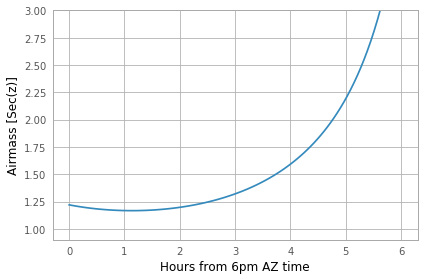

In [47]:
# this gives a Time object with an *array* of times
delta_hours = np.linspace(0, 6, 100)*u.hour
full_night_times = observing_time + delta_hours
full_night_aa_frames = AltAz(location=kitt_peak, obstime=full_night_times)
full_night_aa_coos = hcg7_center.transform_to(full_night_aa_frames)

plt.plot(delta_hours, full_night_aa_coos.secz)
plt.xlabel('Hours from 6pm AZ time')
plt.ylabel('Airmass [Sec(z)]')
plt.ylim(0.9,3)
plt.tight_layout()

Great!  Looks like it's at the lowest airmass in another hour or so (7pm).  But might that might still be twilight... When should we start observing for proper dark skies?  Fortunately, astropy provides a ``get_sun`` function that can be used to check this.  Lets use it to check if we're in 18-degree twilight or not.

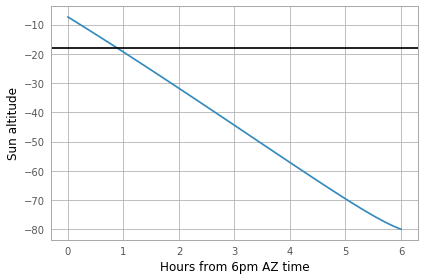

In [48]:
from astropy.coordinates import get_sun

full_night_sun_coos = get_sun(full_night_times).transform_to(full_night_aa_frames)
plt.plot(delta_hours, full_night_sun_coos.alt.deg)
plt.axhline(-18, color='k')
plt.xlabel('Hours from 6pm AZ time')
plt.ylabel('Sun altitude')
plt.tight_layout()

Looks like it's just below 18 degrees at 7, so you should be good to go!

We can also look at the object altitude at the present time and date.  **Today's date seems to be outside the limits of the IERS data, is this a problem??**

In [77]:
now = Time.now()
hcg7_center = SkyCoord(9.81625*u.deg, 0.88806*u.deg, frame='icrs')
kitt_peak_aa = AltAz(location=kitt_peak, obstime=now)
print(hcg7_center.transform_to(kitt_peak_aa))

<SkyCoord (AltAz: obstime=2016-12-21 01:00:00.000, location=(-1994502.6043061386, -5037538.54232911, 3358104.9969029757) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    ( 149.90100038,  55.28257573)>


## Exercises

### Excercise 1

Try to actually compute to some arbitrary precision (rather than eye-balling on a plot) when 18 degree twilight or sunrise/sunset hits on that night.

### Excercise 2

Try converting the HCG7 coordinates to an equatorial frame at some other equinox a while in the past (like J2000).  Do you see the precession of the equinoxes?

Hint: To see a diagram of the supported frames look [here](http://docs.astropy.org/en/stable/coordinates/#module-astropy.coordinates) or the list above. One of those will do what you need if you give it the right frame attributes.

### Excercise 3

Try looking at the altitude of HCG7 at another observatory.

## Wrap-up

For lots more documentation on the many other features of `astropy.coordinates`, check out [its section of the documentation](http://astropy.readthedocs.org/en/latest/coordinates/index.html).

You might also be interested in [the astroplan affiliated package](http://astroplan.readthedocs.org/), which uses the `astropy.coordinates` to do more advanced versions of the tasks in the last section of this tutorial.